# Timeseries decomposition, forecasting and outlier detection

Lets start by loading 7 days of CPU measurements for a lab InfluxDB host. Mean values of CPU usage are binned into buckets of 1 minute. Thus resulting in a set of data 1440 points per day. Since the interval is precise and bouned exacty by midnight, then there is no need to maintain timestamps. This results in a vector of following length.

In [16]:
load("/home/jovyan/data/SDM/rdata/cpu-usage-orig.rda")
print(length(timeseries))

[1] 10080


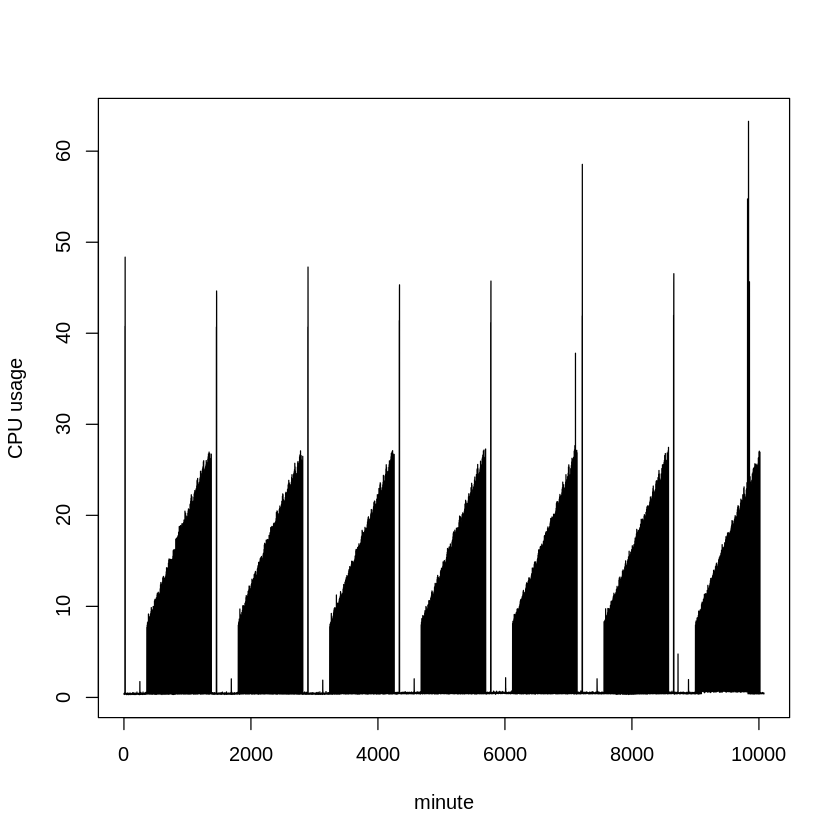

In [17]:
plot(timeseries, type="l", ylab = "CPU usage", xlab = "minute")

There is a clear pattern, but data is quite noisy. We can reduce this noise by binning the data even more, or by smoothing it with a moving average. Former option loses information while the latter introduces delay to real-time anomaly detection. To maintain our resolution of 1440 points per day, I will use the moving average smoothing for now.

In [18]:
ma1 <- function(x, n, sides = 1){
  return(filter(x, rep(1/n,n), sides = sides))
}
timeseries <- ma1(timeseries, n = 15, sides = 1)

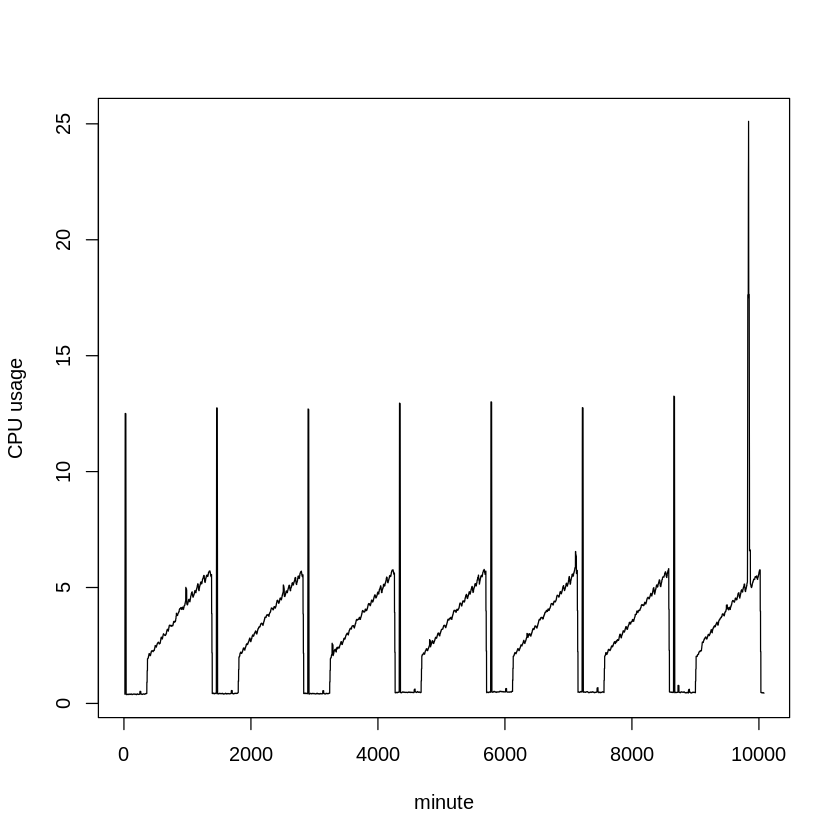

In [19]:
plot(timeseries, type="l", ylab = "CPU usage", xlab = "minute")

Resulting set reduced the amount of noise, while the anomaly on last day is still clearly visible. 

> Note that I used a R filter funciton which applies convolutional filter on timeseries, resulting in a one-sided unweighted moving average. This was done simply to avoid using a for loop. In any reasonable programming language, you can implement something like this (warning! untested out-of-context copypaste code) -

In [21]:
movingAverage <- function(){
    ma1 <- c(rep(NA,4))
    items <- 4
    for( i in seq_along(1:(length(x)-items))){
        set <- x[i:((i-1)+items)]
        ma1[i+items] <- mean(set)
    }
    return(ma1)
}

Autoregressive Moving Average (ARMA) models are commonly used to forecast future timeseries points when historical data with clear seasonal patterns is available. For outlier detection, the idea is to predict past periods and compare these predictions against actual values. This creates an anomaly score for each data point and an alarm can be raised if this score exceeds a certain threshold. Currently, we are only concerned about a single example series, but PCA trick can be used to potentially scale this method to thousands of parallel series.

Firstly, we will separate validation data that will be forecasted from prior training data. For this example, last day will be separated.

In [28]:
total <- length(timeseries)
cycle <- 1440
train <- timeseries[c(1:(total - cycle))]
validate <- timeseries[c( (total-cycle):total )]

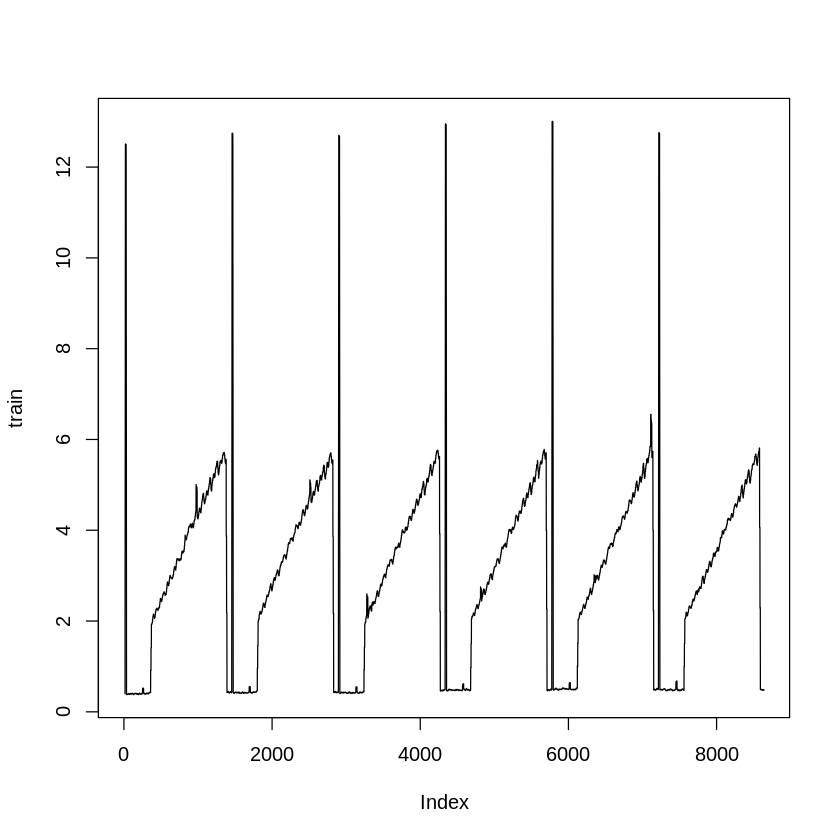

In [29]:
plot(train, type = "l")

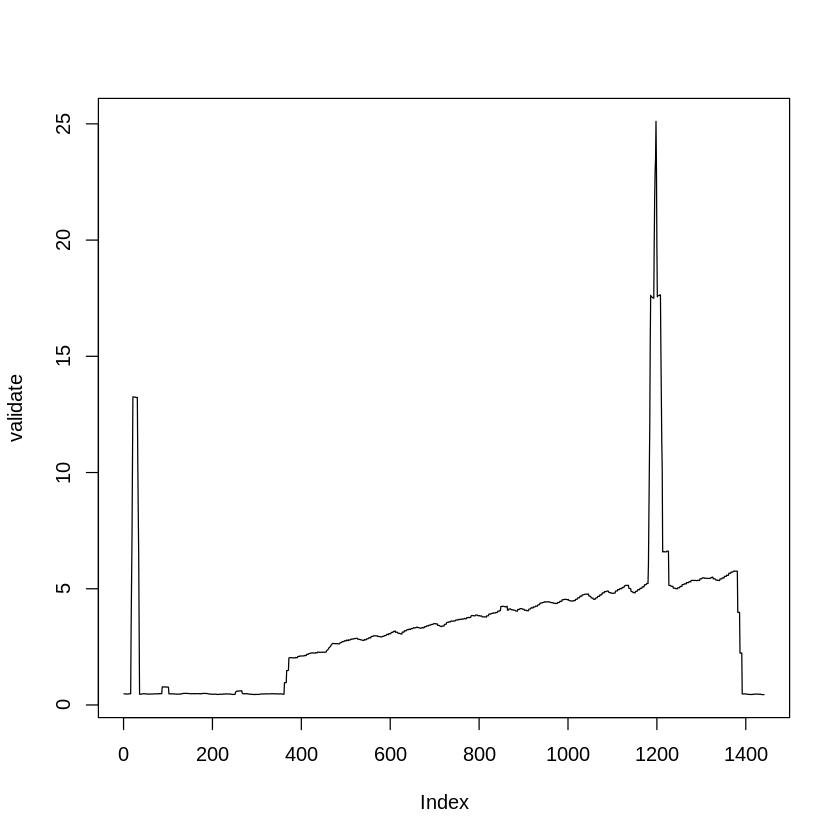

In [30]:
plot(validate, type = "l")

Notice that spike at the beginning of the day is acually not an anomaly when looked at from weekly context. However, the spike at the end of the day is strange and would warrant further inspection.

We have to decompose this series by removing cyclic trend, seasonal pattern and random elements. Additive or multiplicative models can be used depending on the nature of data. Multiplicative can be better when cyclic increase or decrease can be observed while being unsuitable for use on mean-centered normalized data. We will use additive model for this exercise, as no exponential cyclic increase or decrease can be observed.

Cyclic trend can be extracted by calculating weighted moving average.

In [31]:
#trendpatterns <- apply(Ptrunc, 2, ma2, n = SEASONS, slide=TRUE)
ma2 <- function(x, n = 60, slide = TRUE){
  # we do weigted moving average, as opposed to 2-ma of N-ma
  if (slide == TRUE){
    partial <- 1/(n*2)
    filter <- c(partial, rep(1/n, n-1), partial)
  } else {
    filter <- c(rep(1/n, n))
  }
  return(filter(x, filter = filter, sides=2))
}
trend <- ma2(train, n = 1440, slide = TRUE)

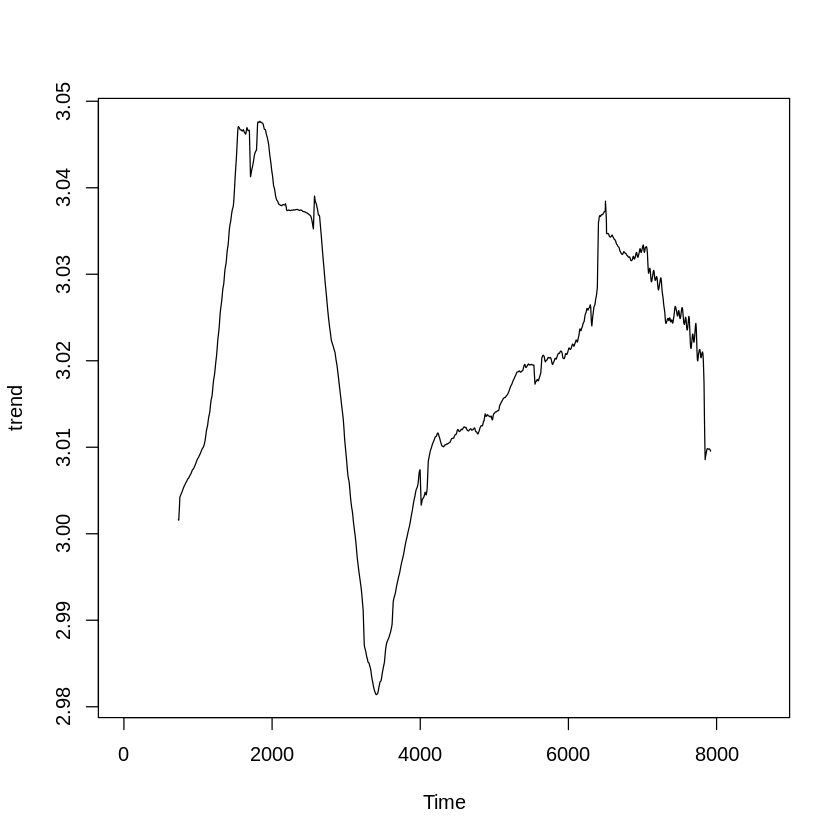

In [32]:
plot(trend, type = "l")

Then we will need to remove trend from series and calculate seasonal coefficients. The latter can simply be calcuating by measuring the average value for every season over available training cycles.

In [33]:
noTrend <- train - trend

In [ ]:
Note that current dataset 

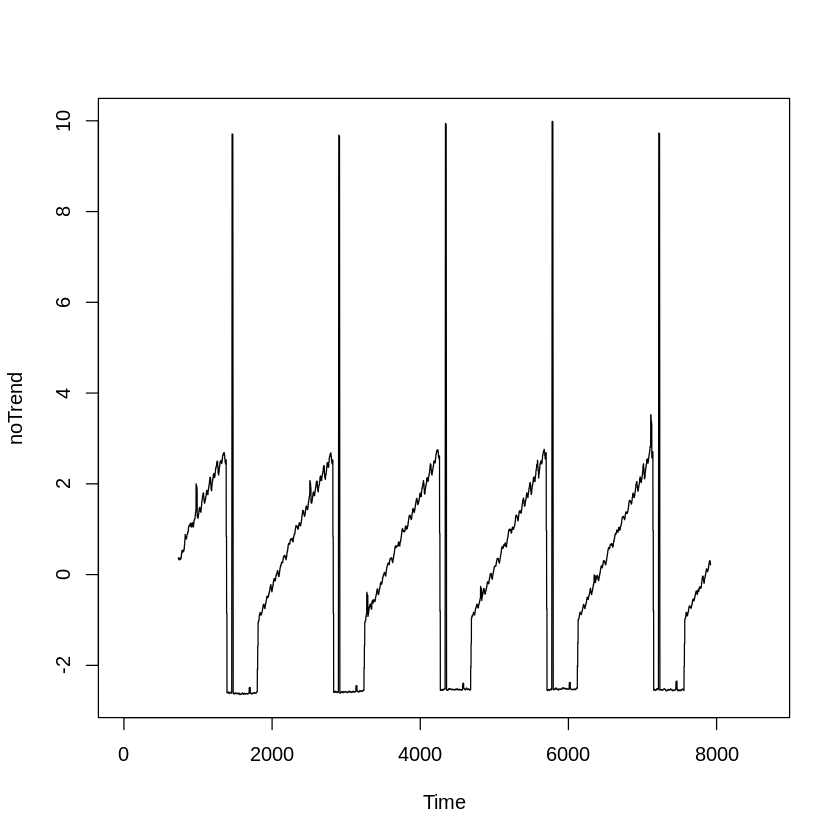

In [34]:
plot(noTrend, type = "l")